#Affichage du graphe

Importation des packages

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import os
os.chdir("C:/Users/Utilisateur/Downloads/TP2")

Se positionner dans le répertoire des données

In [2]:
edge = pd.read_csv("./Data/edges.csv")
features = pd.read_csv("./Data/features.csv")
targets = pd.read_csv("./Data/targets.csv")

In [3]:
edge.head()

,id_1,id_2
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [4]:
targets

,id_,label
0,31336,1
1,1061127,2
2,1106406,3
3,13195,3
4,37879,4
...,...,...
2703,1128975,6
2704,1128977,6
2705,1128978,6
2706,117328,7


In [5]:
targets[targets['id_']==35]['id_']

163    35
Name: id_, dtype: int64

In [6]:
targets['label'].unique()

array([1, 2, 3, 4, 5, 6, 7], dtype=int64)

Création du graphe et du layout

In [7]:
graph=nx.convert_matrix.from_pandas_edgelist(edge,"id_1","id_2")

In [8]:
graph.nodes(data=True)

NodeDataView({35: {}, 1033: {}, 103482: {}, 103515: {}, 1050679: {}, 1103960: {}, 1103985: {}, 1109199: {}, 1112911: {}, 1113438: {}, 1113831: {}, 1114331: {}, 1117476: {}, 1119505: {}, 1119708: {}, 1120431: {}, 1123756: {}, 1125386: {}, 1127430: {}, 1127913: {}, 1128204: {}, 1128227: {}, 1128314: {}, 1128453: {}, 1128945: {}, 1128959: {}, 1128985: {}, 1129018: {}, 1129027: {}, 1129573: {}, 1129683: {}, 1129778: {}, 1130847: {}, 1130856: {}, 1131116: {}, 1131360: {}, 1131557: {}, 1131752: {}, 1133196: {}, 1133338: {}, 1136814: {}, 1137466: {}, 1152421: {}, 1152508: {}, 1153065: {}, 1153280: {}, 1153577: {}, 1153853: {}, 1153943: {}, 1154176: {}, 1154459: {}, 116552: {}, 12576: {}, 128540: {}, 132806: {}, 135130: {}, 141342: {}, 141347: {}, 148170: {}, 15670: {}, 1688: {}, 175291: {}, 178727: {}, 18582: {}, 190697: {}, 190706: {}, 1956: {}, 197054: {}, 198443: {}, 198653: {}, 206371: {}, 210871: {}, 229635: {}, 231249: {}, 248425: {}, 249421: {}, 254923: {}, 259701: {}, 259702: {}, 2632

Attribution des couleurs par rapport aux labels

In [9]:
l=[]
for i in graph.nodes():
    a=targets[targets['id_']==i]['label']
    l.append(int(a))

Affichage du graphe

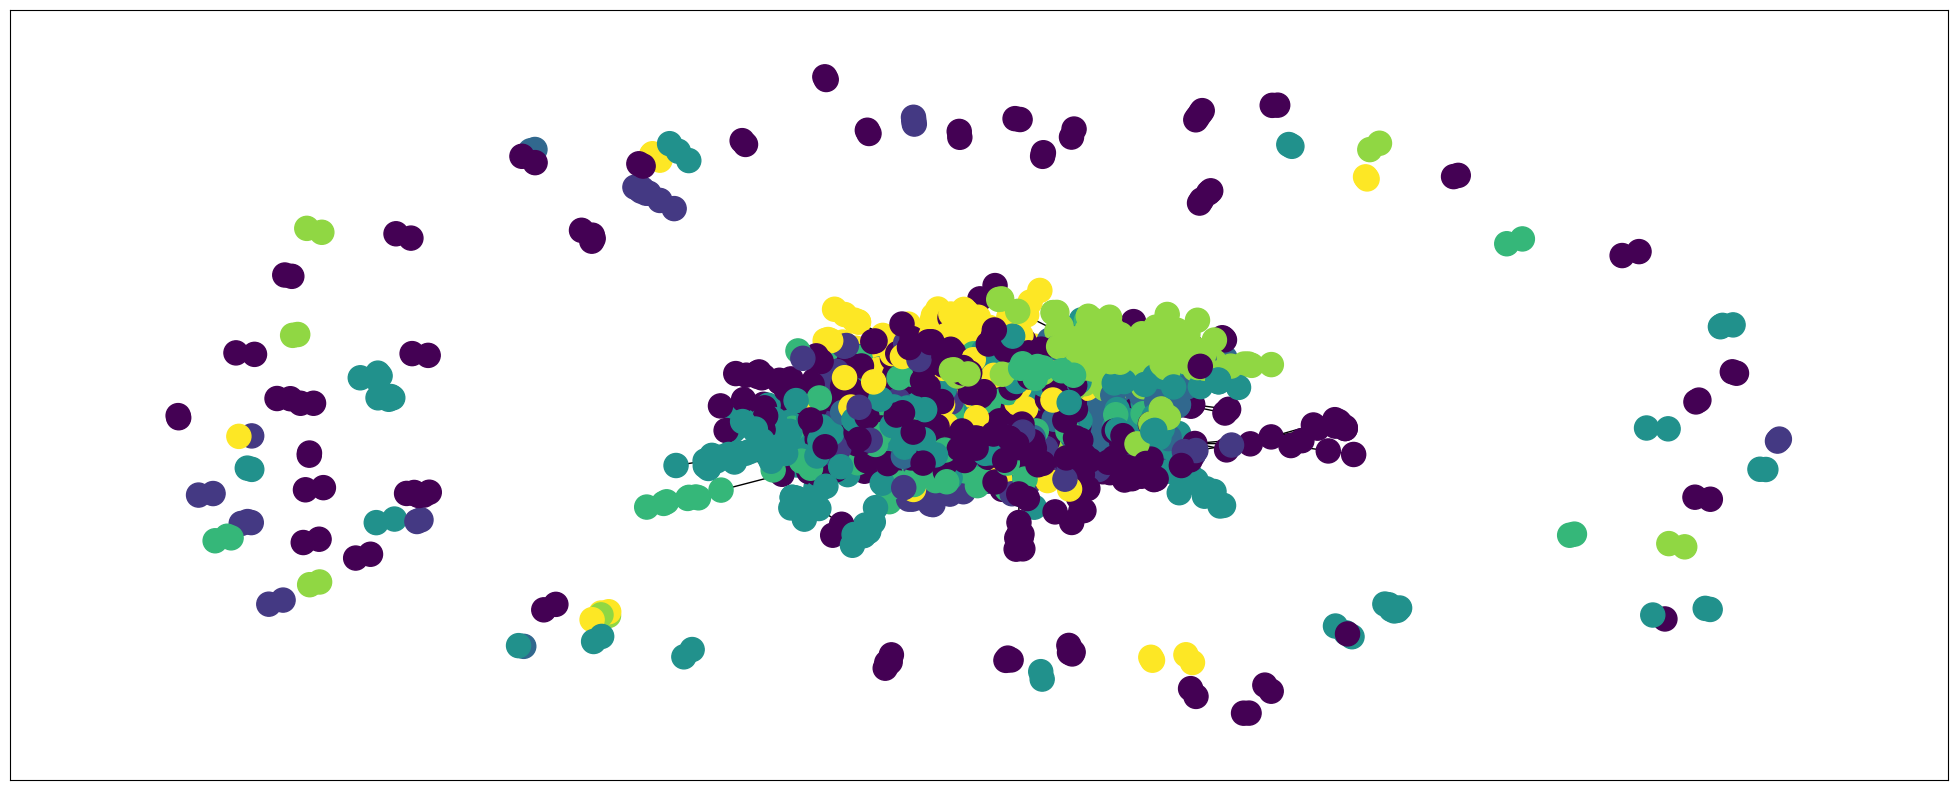

In [10]:
plt.figure(figsize=(25,10))
nx.draw_networkx(graph, with_labels=False,node_color=l) 

#Prétraitement des données


Extraction des données nécessaires

In [11]:
import pickle
with open('./data.pkl', 'rb') as f:
  # read the data back into Python
  data = pickle.load(f)

In [12]:
adj, features, labels, idx_train, idx_val, idx_test = data.get('adj'),data.get('features'),data.get('labels'),data.get('idx_train'),data.get('idx_val'),data.get('idx_test')

Vérification des dimensions

In [13]:
len(adj)

2708

In [14]:
len(features)

2708

In [15]:
len(labels)

2708

In [16]:
len(idx_train)

140

In [17]:
len(idx_val)

300

In [18]:
len(idx_test)

1000

#MLP

##Fonctions utilitaires

Nombre de paramètres d'un modèle

In [19]:
def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) 

Prédictions correctes

In [20]:
def get_predictions(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    return correct

Calcul de l'accuracy

In [21]:
def accuracy(output, labels):
    correct = get_predictions(output, labels)
    correct = correct.sum()
    return correct/len(labels)

Calcul de l'accuracy d'un MLP

In [22]:
def mlp_accuracy(model,lab,data):
    """
    Perfom a forward pass `y_pred = model(x)` and computes the accuracy
    between `y_pred` and `y_true`
    """
    model.eval()
    y_pred = model(data)
    acc = accuracy(y_pred, lab)
    print(f"Accuracy: {acc:.5}")
    return

##Modèle MLP

Conception du modèle

In [23]:
import torch.nn as nn
mlp = nn.Sequential(
      nn.Linear(1433, 500),
      nn.ReLU(),
      nn.Linear(500, 100),
      nn.ReLU(),
      nn.Linear(100, 7)
    )

##MLP sans entrainement

Affichage de l'accuracy

In [24]:
print("Accuracy before training")
mlp_accuracy(mlp, labels[idx_train], features[idx_train])

Accuracy before training
Accuracy: 0.29286


##MLP avec entrainement


Entrainer le modèle MLP

In [25]:
import torch.optim as optim
from tqdm import trange 
import torch.nn.functional as F

opt = optim.Adam(mlp.parameters())

losses = []
mlp.train()

for epoch in trange(3000):
    opt.zero_grad()
    output = mlp(features[idx_train])
    loss = F.cross_entropy(output, labels[idx_train])
    loss.backward()
    opt.step()
    losses.append(loss.item())

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:21<00:00, 140.73it/s]


Affichage de l'accuracy

In [26]:
print("Loss after training")
mlp_accuracy(mlp, labels[idx_test], features[idx_test])

Loss after training
Accuracy: 0.511


Nombre de paramètres du modèle MLP

In [27]:
print('Number of parameters MLP: ', num_params(mlp))

Number of parameters MLP:  767807


#GCN

##Couche GCN

COnception d'une couche

In [28]:
from torch.nn import Parameter
import torch
import math
class GraphConvolution(nn.Module):

    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.weight = Parameter(torch.FloatTensor(in_features,out_features))
        self.bias = Parameter(torch.FloatTensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        stdev = 1./math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdev,stdev)
        self.bias.data.uniform_(-stdev, stdev)

    def forward(self, inputs, adj):
        support = torch.mm(inputs,self.weight)
        output = torch.mm(adj,support)

        return output + self.bias

##Modèle GCN

Conception du modèle 

In [29]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass):
        super(GCN, self).__init__()
        self.gcn1 = GraphConvolution(nfeat,nhid)
        self.gcn2 = GraphConvolution(nhid, nclass)
    def forward(self, x, adj):
        x = F.relu(self.gcn1(x,adj))
        return self.gcn2(x,adj)

##Fonction d'évaluation

Calcul de l'accuracy d'un modèle GCN

In [30]:
def gcn_accuracy(model, inputs, adj):

    model.eval()
    y_pred =  model(inputs, adj)
    acc =  accuracy(y_pred[idx_test], labels[idx_test])
    print(f"Accuracy: {acc:.5}")
    return acc

##Cas de test

Tester le modèle GCN

In [31]:
gcn = GCN(1433,128,7)

##Evaluation sans entrainement 

Affichage de l'accuracy avant entrainement

In [32]:
print("Loss before training")
gcn_accuracy(gcn, features, adj)

Loss before training
Accuracy: 0.138


tensor(0.1380, dtype=torch.float64)

##Evaluation avec entrainement

Entrainer le modèle GCN

In [33]:
opt = optim.Adam(gcn.parameters())

losses = []
gcn.train()

for epoch in trange(500):
    opt.zero_grad()
    output = gcn(features,adj)
    loss = F.cross_entropy(output[idx_train], labels[idx_train])
    loss.backward()
    opt.step()
    losses.append(loss.item())

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 61.52it/s]


Affichage de l'accuracy après entrainement

In [34]:
print("Loss after training")
gcn_accuracy(gcn, features, adj)

Loss after training
Accuracy: 0.816


tensor(0.8160, dtype=torch.float64)

Affichage du nombre de paramètres du modèle GCN

In [35]:
print('Number of parameters GCN: ',num_params(gcn))

Number of parameters GCN:  184455
